In [6]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
from scipy.integrate._ivp.rk import RK45, RK23, DOP853
import time

# Add the parent directory to sys.path to import invflow modules
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Import ConservativeODE for setting up the problem
from homproj.dynamics import HamiltonianSystem
from homproj.adaptive import create_projected_solver

# Set initial conditions and simulation parameters


# Set up the double pendulum problem using ConservativeODE
q1, q2, p1, p2 = sp.symbols('q1 q2 p1 p2', real=True)
variables = [q1, q2, p1, p2]
H_sym = (p1**2 + 2*p2**2 - 2*sp.cos(q1 - q2)*p1*p2)/(4 - 2*sp.cos(q1 - q2)**2) + 1/2*q1**2 + 1/2*q2**2
invariants = [H_sym]
f_pendulum = HamiltonianSystem(H_sym, variables).f

H_fun = sp.lambdify(variables, H_sym, 'numpy')

def compute_energy(state):
    if state.ndim == 1:
        return H_fun(*state)
    else:
        return np.array([H_fun(*row) for row in state])

def f(t, y):
    return f_pendulum(y)




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def G(y):
    y1,y2,y3,y4 = y
    return 0.5*y1**2 + 0.5*y2**2 + y3**2 + y4**2

def phi(x):
    x1,x2,x3,x4 = x
    c12 = np.cos(x1 - x2)
    D   = np.sqrt(2.0 - c12*c12)
    y1  = x1
    y2  = x2
    y3  =  0.5*x3
    y4  = (2.0*x4 - c12*x3)/(2.0*D)
    return np.array([y1,y2,y3,y4])

def phi_inv(y, x_prev=None):
    y1,y2,y3,y4 = y
    x1 = y1
    x2 = y2
    x3 = 2.0*y3
    c12 = np.cos(x1 - x2)
    D   = np.sqrt(2.0 - c12*c12)
    x4  = 0.5*c12*x3 + D*y4
    return np.array([x1,x2,x3,x4])
k = 2
t = 0.01
x = np.array([0.5, 1.0, 2.0, 1.0])
exp = np.exp(np.array([1, 1, 1, 1])*t)
psi = lambda x: phi_inv(exp*phi(x))
print('conjugate invariant: ', G(phi(x))-H_fun(*x))
print('homogeneous in conjugate space: ', G(exp*phi(x)) - np.exp(k*t)*G(phi(x)))
print('c-homogeneous in physical space: ', H_fun(*phi_inv(exp*phi(x)))-np.exp(k*t)*H_fun(*x))


conjugate invariant:  0.0
homogeneous in conjugate space:  -2.220446049250313e-16
c-homogeneous in physical space:  -4.440892098500626e-16


In [12]:
from homproj.linhomproj import LinearHomogeneousProjector
from homproj import HomogeneousProjector
from homproj import Projector
from homproj.numeric import gll4, gll6, pseudo_symplectic, rk4


def init_solver_methods(initial_state):
    pseudo_hom_proj = HomogeneousProjector(
        invariants=H_fun,
        initial_state=initial_state,
        integrator='rk2',
        max_iterations=1,
    )

    conj_hom_proj = LinearHomogeneousProjector(
        invariant=H_fun,
        generator=np.array([1, 1, 1, 1]),
        degree=2,
        initial_state=initial_state,
        phi=phi,
        phi_inv=phi_inv,
    )

    rk4_proj = lambda x, h, f: pseudo_hom_proj.project(rk4(x, h, f))
    rk4_proj_c = lambda x, h, f: conj_hom_proj.project(rk4(x, h, f))

    # List of (label, method) pairs to test
    solver_methods = [
        ('RK4', rk4), # fixed step size
        ('CH RK4', rk4_proj_c), # fixed step size
        ('PNH RK4', rk4_proj), # fixed step size
        ('PS4(9)', pseudo_symplectic),
        ('GLL4', gll4),
        ('Reference', DOP853),
    ]
    return solver_methods





In [13]:
from scipy.integrate._ivp.base import OdeSolver
from dputils import plot_trajectories, plot_analysis_over_initial_conditions, run_experiment



0
2.4845719039367116
Running RK4...
Running CH RK4...
Running PNH RK4...
Running PS4(9)...
Running GLL4...
Running Reference...


/Users/bentapley/Library/Mobile Documents/com~apple~CloudDocs/Code-SINTEF/invariant-preservation/venv/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,


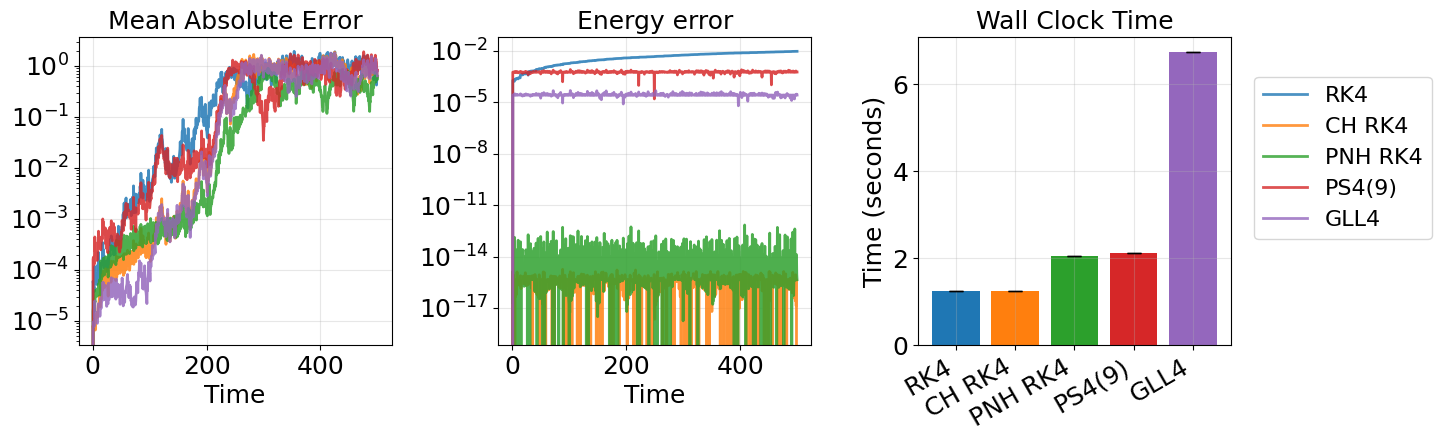

1
2.498565211474477
Running RK4...
Running CH RK4...
Running PNH RK4...
Running PS4(9)...
Running GLL4...
Running Reference...


/Users/bentapley/Library/Mobile Documents/com~apple~CloudDocs/Code-SINTEF/invariant-preservation/venv/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,


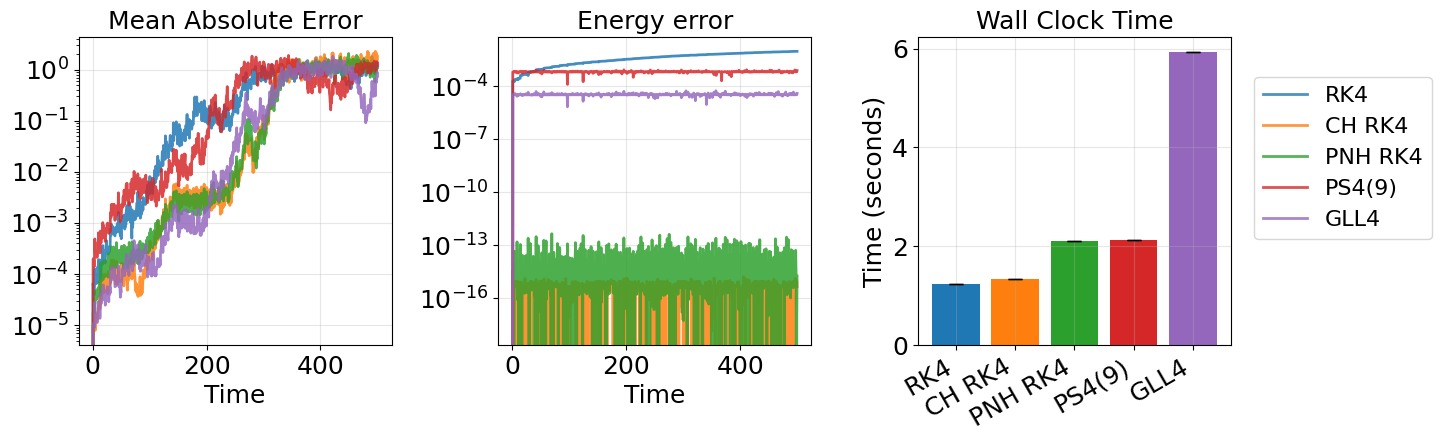

2
2.4997302458848876
Running RK4...
Running CH RK4...
Running PNH RK4...
Running PS4(9)...
Running GLL4...
Running Reference...


/Users/bentapley/Library/Mobile Documents/com~apple~CloudDocs/Code-SINTEF/invariant-preservation/venv/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,


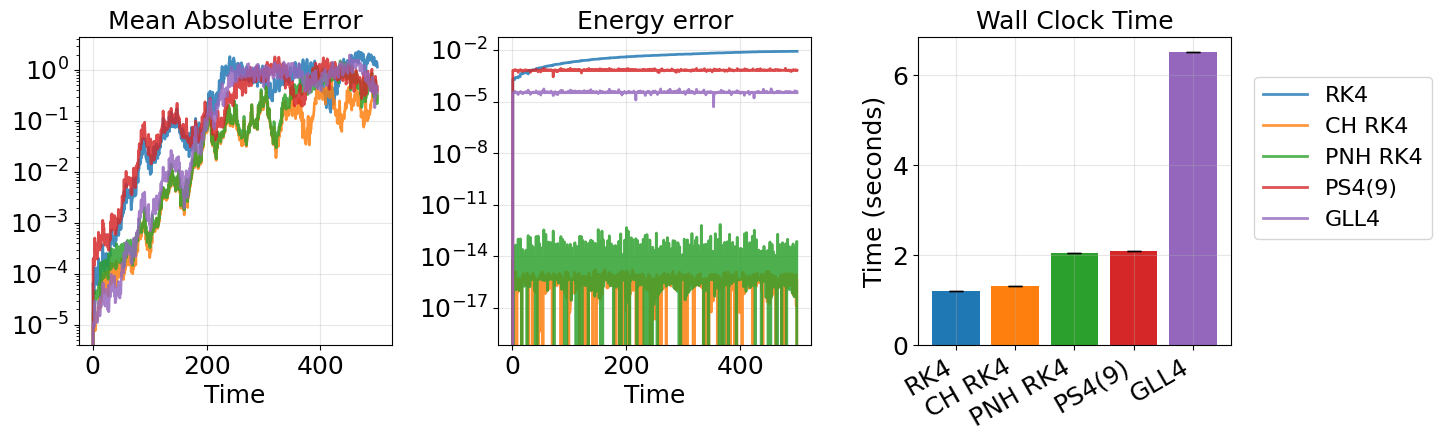

3
2.481581383415741
Running RK4...
Running CH RK4...
Running PNH RK4...
Running PS4(9)...
Running GLL4...
Running Reference...


/Users/bentapley/Library/Mobile Documents/com~apple~CloudDocs/Code-SINTEF/invariant-preservation/venv/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,


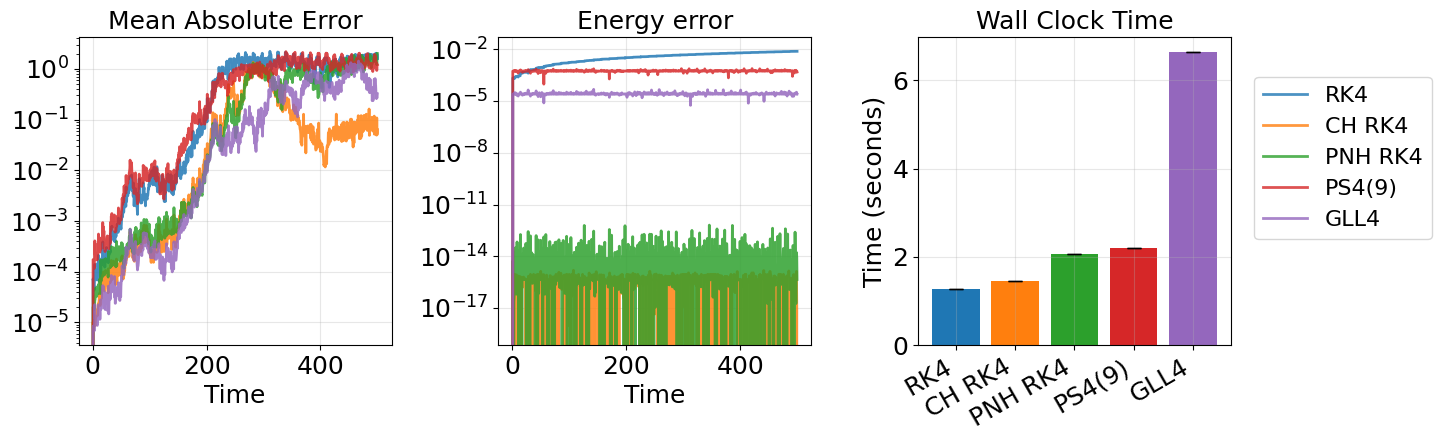

4
2.5017608460163747
Running RK4...
Running CH RK4...
Running PNH RK4...
Running PS4(9)...
Running GLL4...
Running Reference...


/Users/bentapley/Library/Mobile Documents/com~apple~CloudDocs/Code-SINTEF/invariant-preservation/venv/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,


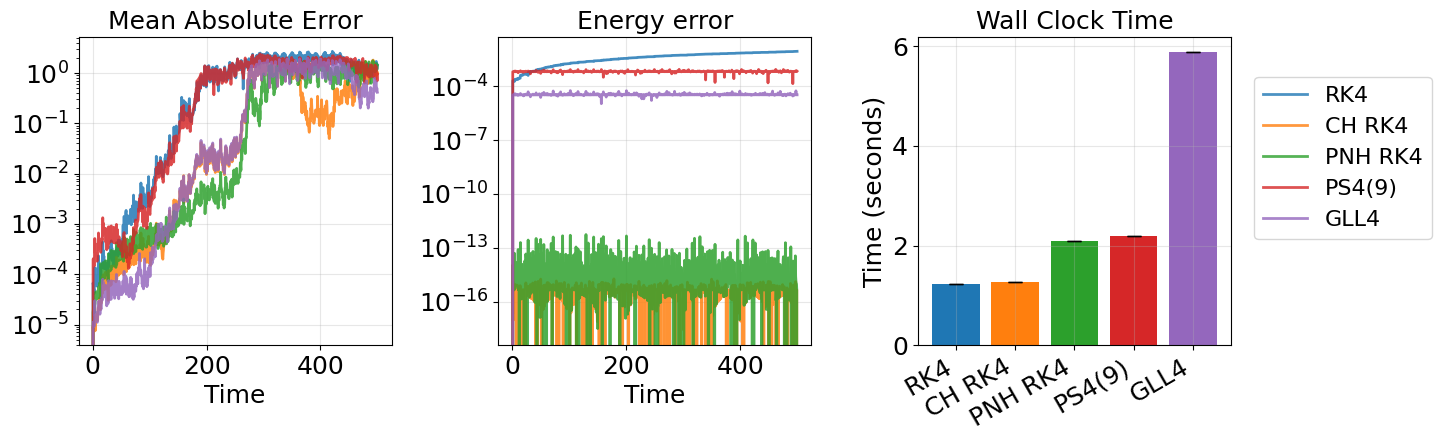

5
2.4992953995586604
Running RK4...
Running CH RK4...
Running PNH RK4...
Running PS4(9)...
Running GLL4...
Running Reference...


/Users/bentapley/Library/Mobile Documents/com~apple~CloudDocs/Code-SINTEF/invariant-preservation/venv/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,


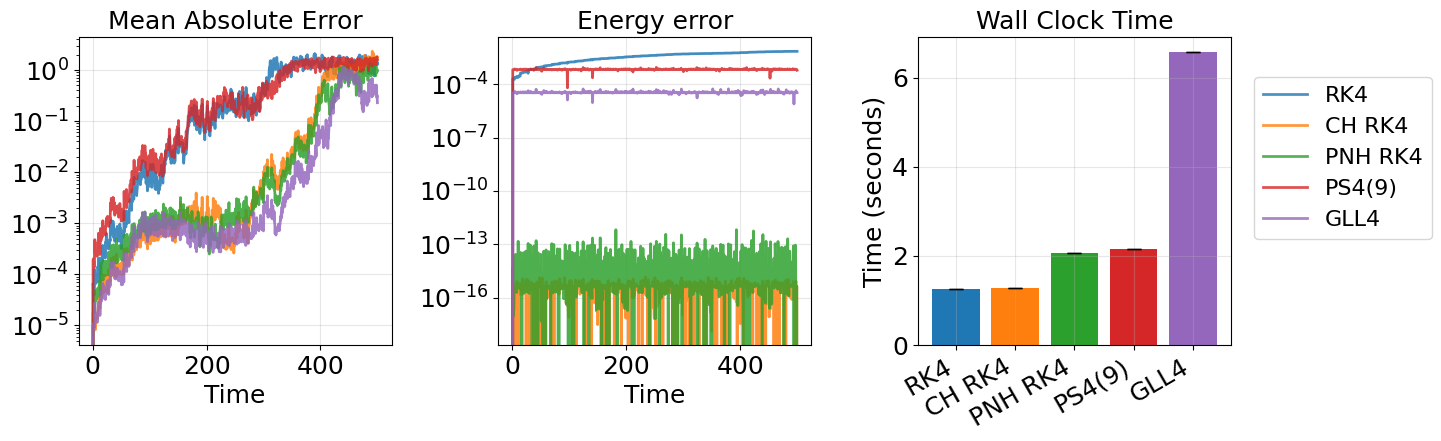

6
2.4855645510157856
Running RK4...
Running CH RK4...
Running PNH RK4...
Running PS4(9)...
Running GLL4...
Running Reference...


/Users/bentapley/Library/Mobile Documents/com~apple~CloudDocs/Code-SINTEF/invariant-preservation/venv/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,


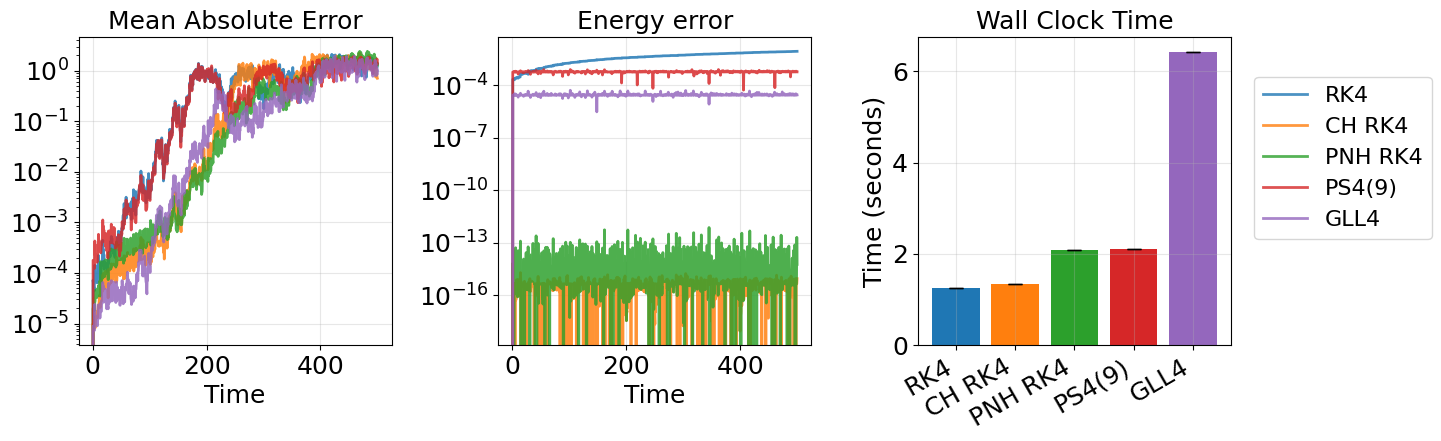

7
2.461084444532605
Running RK4...
Running CH RK4...
Running PNH RK4...
Running PS4(9)...
Running GLL4...
Running Reference...


/Users/bentapley/Library/Mobile Documents/com~apple~CloudDocs/Code-SINTEF/invariant-preservation/venv/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,


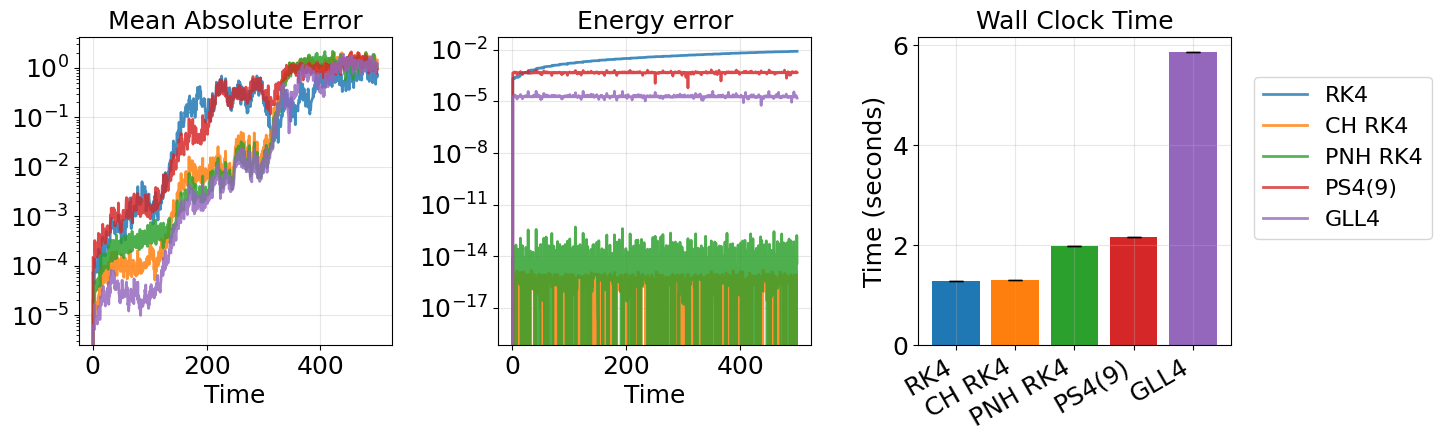

8
2.4870803703641737
Running RK4...
Running CH RK4...
Running PNH RK4...
Running PS4(9)...
Running GLL4...
Running Reference...


/Users/bentapley/Library/Mobile Documents/com~apple~CloudDocs/Code-SINTEF/invariant-preservation/venv/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,


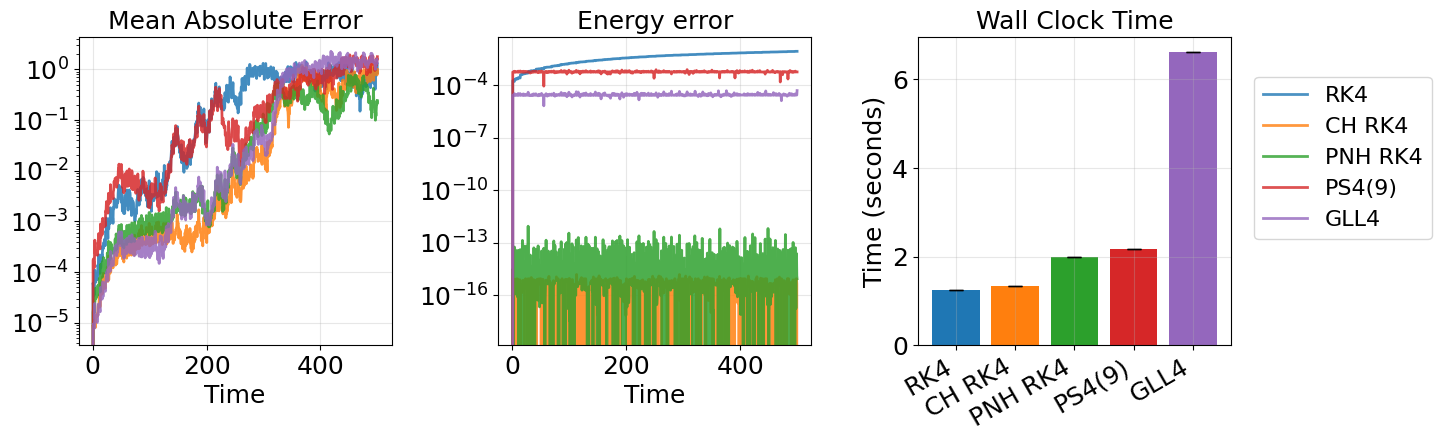

9
2.437438580360117
Running RK4...
Running CH RK4...
Running PNH RK4...
Running PS4(9)...
Running GLL4...
Running Reference...


/Users/bentapley/Library/Mobile Documents/com~apple~CloudDocs/Code-SINTEF/invariant-preservation/venv/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,


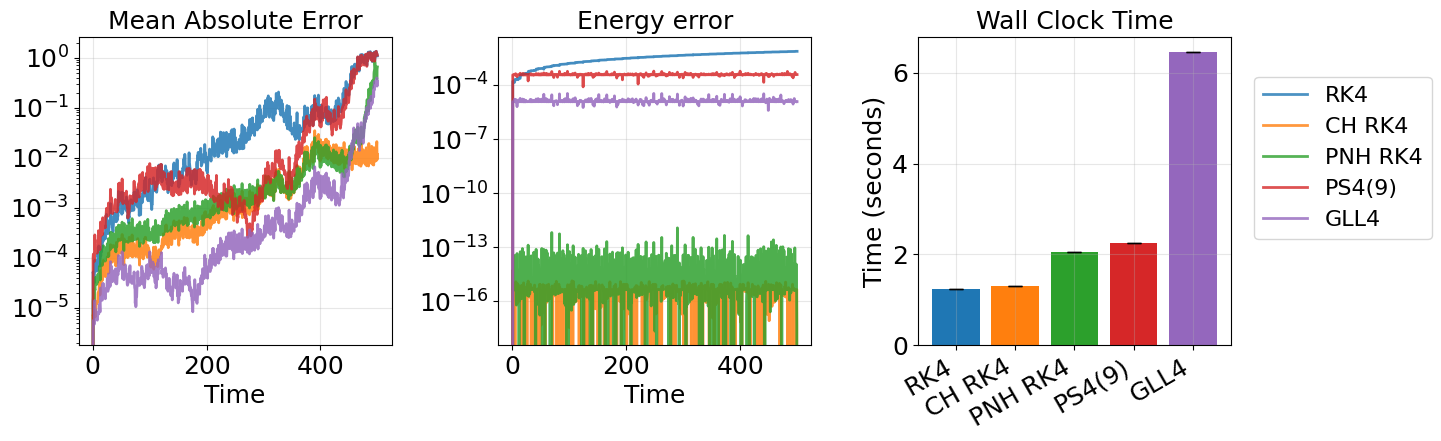

Completed 10 experiments with different initial conditions


In [16]:

np.random.seed(2)

n_runs = 10
tmax=500
tol=1e-5
timestep=0.05

solutions_list = []
timings_list = []
initial_energy_list = []

def run_single_experiment(i, tmax, tol, timestep, f):
    # Set up initial state with random second angle
    a = np.random.uniform(-0.1, 0.1)
    b = np.random.uniform(-0.1, 0.1)
    y0 = np.array([a, b, 1, -1])

    initial_energy = compute_energy(y0)
    print(initial_energy)
    solver_methods = init_solver_methods(y0)
    solutions, timings = run_experiment(solver_methods, y0, tmax, tol, timestep, f)
    return solutions, timings, initial_energy

for i in range(n_runs):
    print(i)
    solutions, timings, initial_energy = run_single_experiment(i, tmax=tmax, tol=tol, timestep=timestep, f=f)

    fig_combined = plot_analysis_over_initial_conditions(
        solutions_list=[solutions],
        compute_energy=compute_energy,
        initial_energies=[initial_energy],
        timings=[timings],
    )
    plt.show()

    solutions_list.append(solutions)
    timings_list.append(timings)
    initial_energy_list.append(initial_energy)

print(f"Completed {n_runs} experiments with different initial conditions")



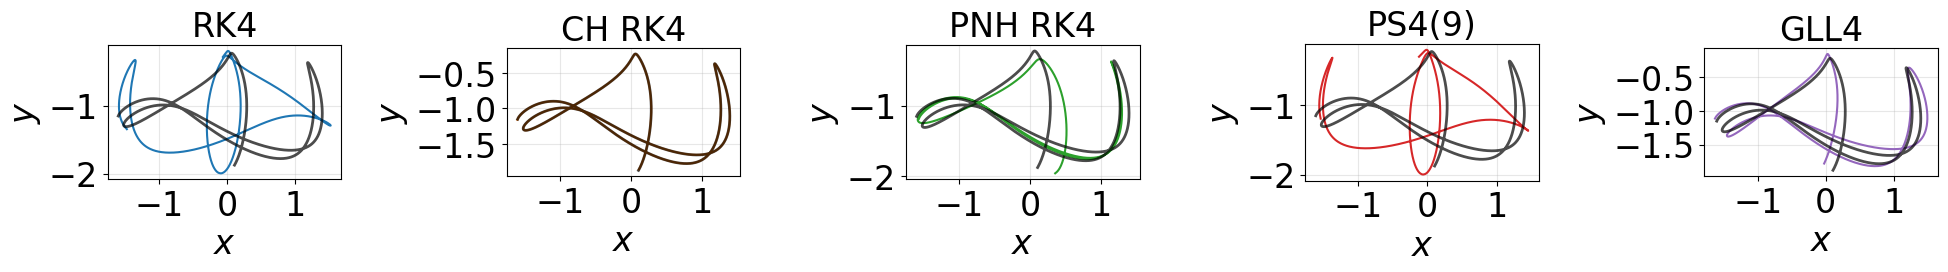

In [85]:
# Create trajectory visualizations
fig_traj = plot_trajectories(
    solutions=solutions,
    start_time=475,
    end_time=485,
)
plt.show()
fig_combined.savefig('../figs/double_pendulum_torsioned_joints_475-485_adaptive.png', dpi=300, bbox_inches='tight')


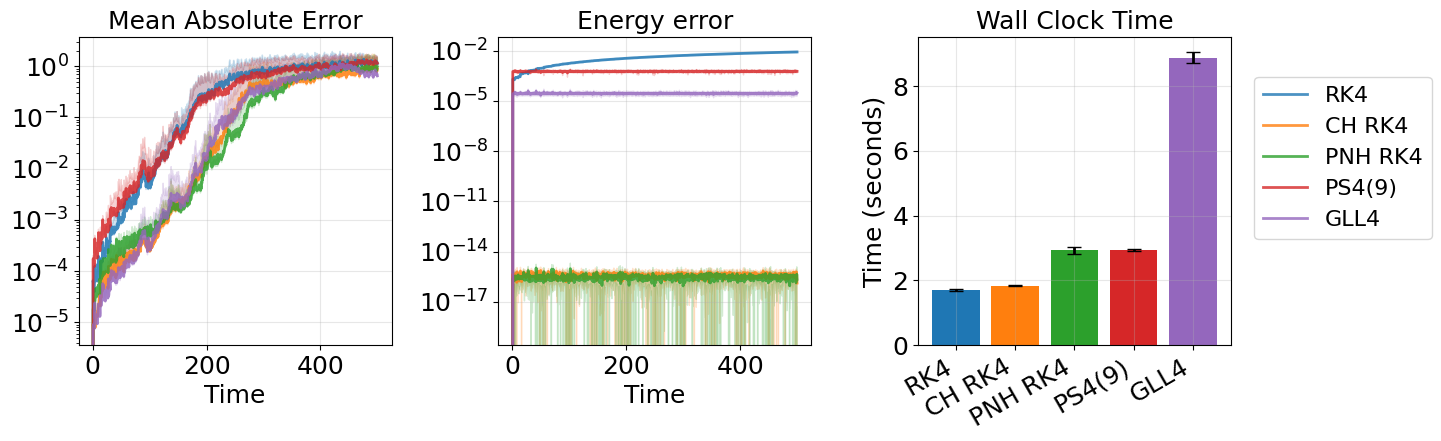

In [92]:
# Create time series, energy and performance visualizations in a single figure
# For a single initial condition, wrap solutions in a list
fig_combined = plot_analysis_over_initial_conditions(
    solutions_list=solutions_list,
    compute_energy=compute_energy,
    initial_energies=initial_energy_list,
    timings=timings_list,
    # plot_std=True,
)
plt.show()

fig_combined.savefig('../figs/double_pendulum_torsioned_joint_adaptive.png', dpi=300, bbox_inches='tight')


In [ ]:
# Create an animated GIF of the double pendulum simulation
from dputils import create_pendulum_animation
if False:
    animation = create_pendulum_animation(
        solutions=solutions,
        compute_energy=compute_energy,
        initial_energy=initial_energy,
        filename='double_pendulum_energy_preservation.gif',
        fps=20,
        time_step=0.1
    )

    # Display the animation in the notebook (this may not work in all environments)
    # If it doesn't work, you can open the saved GIF file directly
    from IPython.display import Image
    try:
        display(Image(filename='double_pendulum_energy_preservation.gif'))
        print("Animation displayed successfully!")
    except (IOError, RuntimeError, ValueError) as e:
        print(f"Animation saved but couldn't display it in the notebook: {e}")
        print("Please open 'double_pendulum_energy_preservation.gif' to view the animation.")

# Cost error plots


In [20]:
# use adaptive methods now
def init_solver_methods(initial_state):
    pseudo_hom_proj = HomogeneousProjector(
        invariants=invariants[0],
        variables=variables,
        initial_state=initial_state,
        integrator='rk2',
        max_iterations=1,
    )

    conj_hom_proj = LinearHomogeneousProjector(
        invariant=invariants[0],
        variables=variables,
        generator=np.array([1, 1, 1, 1]),
        degree=2,
        initial_state=initial_state,
        phi=phi,
        phi_inv=phi_inv,
    )

    rk4_proj = lambda x, h, f: pseudo_hom_proj.project(rk4(x, h, f))
    rk4_proj_c = lambda x, h, f: conj_hom_proj.project(rk4(x, h, f))

    # List of (label, method) pairs to test
    solver_methods = [
        ('RK45', RK45),
        ('CH Projection', create_projected_solver(RK45, conj_hom_proj)),
        ('PNH Projection', create_projected_solver(RK45, pseudo_hom_proj)),
        ('PS4(9)', pseudo_symplectic),
        ('GLL4', gll4),
        ('GLL6', gll6),
        ('Reference', DOP853),
    ]
    return solver_methods

In [21]:
# Parameter sweep experiment for different timesteps and tolerances
import pandas as pd
import matplotlib.pyplot as plt

# Define parameter ranges
n_params = 5
timestep_range = np.logspace(-3, -1, n_params)  # From 0.001 to 0.1
tol_range = np.logspace(-12, -4, n_params)  # From 1e-12 to 1e-4
tmax = 50  # Shorter simulation for parameter sweep

# Fixed initial condition for consistent comparison
y0 = np.array([0.1, -0.05, 1.5, -1.2])
print(f"Testing {len(timestep_range)} timesteps and {len(tol_range)} tolerances")
print(f"Total combinations: {len(timestep_range) * len(tol_range)}")

# Store results
param_results = []

for i, (timestep, tol) in enumerate(zip(timestep_range, tol_range)):
        print(f"\nTimestep {i+1}/{len(timestep_range)}, Tolerance {i+1}/{len(tol_range)}: dt={timestep:.4f}, tol={tol:.1e}")

        try:
            solver_methods = init_solver_methods(y0)
            solutions, timings = run_experiment(solver_methods, y0, tmax, tol, timestep, f=f)
            
            # Find reference solution
            ref_sol = None
            for name, sol in solutions.items():
                if 'reference' in name.lower() and sol.success:
                    ref_sol = sol
                    break
                    
            if ref_sol is None:
                print("  No reference solution found.")
                continue
                
            ref_final = ref_sol.y[:, -1]
            ref_norm = np.linalg.norm(ref_final)
            
            # Calculate final state error for each method
            for name, sol in solutions.items():
                if sol.success and 'reference' not in name.lower():
                    method_final = sol.y[:, -1]
                    error = np.linalg.norm(method_final - ref_final)
                    rel_error = error / ref_norm if ref_norm > 0 else error
                    
                    param_results.append({
                        'Method': name,
                        'Timestep': timestep,
                        'Tolerance': tol,
                        'Runtime': timings[name],
                        'Final_Error': rel_error,
                        'Success': True
                    })
                elif not sol.success and 'reference' not in name.lower():
                    param_results.append({
                        'Method': name,
                        'Timestep': timestep,
                        'Tolerance': tol,
                        'Runtime': float('inf'),
                        'Final_Error': float('inf'),
                        'Success': False
                    })
                    
        except Exception as e:
            print(f"  Error: {e}")
            # Add failed entries for all non-reference methods
            for name, _ in solver_methods:
                if 'reference' not in name.lower():
                    param_results.append({
                        'Method': name,
                        'Timestep': timestep,
                        'Tolerance': tol,
                        'Runtime': float('inf'),
                        'Final_Error': float('inf'),
                        'Success': False
                    })

# Convert to DataFrame
df_results = pd.DataFrame(param_results)
print(f"\nCompleted parameter sweep. Total results: {len(df_results)}")

Testing 5 timesteps and 5 tolerances
Total combinations: 25

Timestep 1/5, Tolerance 1/5: dt=0.0010, tol=1.0e-12
Running RK45...
Running CH Projection...
Running CH Projection...
Running PNH Projection...
Running PNH Projection...
Running PS4(9)...
Running PS4(9)...
Running GLL4...
Running GLL4...
Running GLL6...
Running GLL6...
Running Reference...
Running Reference...


/Users/bentapley/Library/Mobile Documents/com~apple~CloudDocs/Code-SINTEF/invariant-preservation/venv/lib/python3.9/site-packages/scipy/integrate/_ivp/rk.py:505: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,



Timestep 2/5, Tolerance 2/5: dt=0.0032, tol=1.0e-10
Running RK45...
Running CH Projection...
Running CH Projection...
Running PNH Projection...
Running PNH Projection...
Running PS4(9)...
Running PS4(9)...
Running GLL4...
Running GLL4...
Running GLL6...
Running GLL6...
Running Reference...
Running Reference...

Timestep 3/5, Tolerance 3/5: dt=0.0100, tol=1.0e-08
Running RK45...

Timestep 3/5, Tolerance 3/5: dt=0.0100, tol=1.0e-08
Running RK45...
Running CH Projection...
Running CH Projection...
Running PNH Projection...
Running PNH Projection...
Running PS4(9)...
Running PS4(9)...
Running GLL4...
Running GLL4...
Running GLL6...
Running GLL6...
Running Reference...
Running Reference...

Timestep 4/5, Tolerance 4/5: dt=0.0316, tol=1.0e-06
Running RK45...
Running CH Projection...

Timestep 4/5, Tolerance 4/5: dt=0.0316, tol=1.0e-06
Running RK45...
Running CH Projection...
Running PNH Projection...
Running PS4(9)...
Running GLL4...
Running PNH Projection...
Running PS4(9)...
Running GLL4.

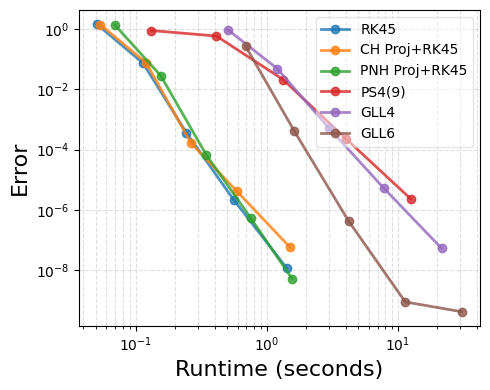

In [33]:
# Plot Final State Error vs Runtime
plt.figure(figsize=(5, 4))

# Filter out failed runs and exclude reference
df_success = df_results[df_results['Success'] & (df_results['Final_Error'] != float('inf'))]
df_methods = df_success[~df_success['Method'].str.contains('Reference', case=False, na=False)].copy()

# Create color scheme
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {name: color_cycle[i % len(color_cycle)] for i, name in enumerate(df_methods['Method'].unique())}

# Plot each method
for method in df_methods['Method'].unique():
    method_data = df_methods[df_methods['Method'] == method]
    if not method_data.empty:
        # Sort by runtime for cleaner visualization
        method_label = method.replace("Projection", "Proj+RK45")
        method_data_sorted = method_data.sort_values('Runtime')
        plt.loglog(method_data_sorted['Runtime'], method_data_sorted['Final_Error'],
                   'o-', color=colors[method], label=method_label, markersize=6, linewidth=2, alpha=0.8)

plt.xlabel('Runtime (seconds)', fontsize=16)
plt.ylabel('Error', fontsize=16)
plt.title('', fontsize=16)
plt.grid(True, which='both', alpha=0.4, linestyle='--')
plt.legend(fontsize=10, loc='best', framealpha=0.5)

# Add simulation info
# plt.text(0.02, 0.98, f'Simulation time: {tmax}s\nParameter combinations: {len(timestep_range)}×{len(tol_range)}', 
#          transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
#          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.savefig('../figs/error_vs_runtime_adaptive_torsioned_dp.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()